## Objetivos 
Predecir el perfil crediticio de los clientes potenciales, clasificandolos  en categorias **buenos** y **malos**.

##### Importando librerias

In [613]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore", message="my warning message")

##### Abriendo Datasets

In [614]:
path1 = r'C:\Users\sebastian sossa\Documents\tangelo\credit_record (2).csv'
path2 = r'C:\Users\sebastian sossa\Documents\tangelo\application_record (2).csv'
df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)
original = pd.read_csv(path2)

In [615]:
print(df1.shape)
print(df2.shape)

(1048575, 3)
(438557, 18)


## Data Cleaning 

### Application record

##### Descripcion

* ID -> Client number
* CODE_GENDER -> Gender
* FLAG_OWN_CAR -> Is there a car
* FLAG_OWN_REALTY -> Is there a property
* CNT_CHILDREN -> Number of children
* AMT_INCOME_TOTAL -> Anual income
* NAME_INCOME_TYPE -> Income category
* NAME_EDUCATION_TYPE -> Income category
* NAME_FAMILY_SATATUS -> Marital status
* NAME_HOUSING_TYPE -> Way of living 
* DAYS_BIRTH -> Birthday: Counts backwars from current day (0), -1 means yesterday
* DAYS_EMPLOYED -> Start date of employment: Count backwards from current day (0). If positive, it means the person is currently unemployed
* FLAG_MOBIL -> Is there a mobile phone 
* FLAG_WORK_PHONE -> Is there a work phone 
* FLAG_PHONE -> Is there a phone 
* FLAG_EMAIL -> Is there an email
* OCUPATION_TYPE -> Occupation 
* CNT_FAM_MEMBERS -> Family size

In [616]:
df2.shape

(438557, 18)

##### Convertimos los dias nacido y calculamos la edad

In [617]:
df2['DAYS_BIRTH'] = df2['DAYS_BIRTH'].abs()

In [618]:


# definir una función para convertir días de nacimiento a edad en años
def dias_a_anios(dias):
    fecha_nacido = dt.date.today() - dt.timedelta(days=dias)
    anios = int((dt.date.today() - fecha_nacido).days / 365.25)
    return anios

# aplicar la función a la columna 'DAYS_BIRTH' utilizando el método apply()
df2['AGE'] = df2['DAYS_BIRTH'].apply(dias_a_anios)

##### Creamos una nueva columna, llamado empleado, 0 = No, 1 = si, y calculamos los dias de empleado

In [619]:
# Determinamos si la persona esta empleada actualmente
def es_empleado(days):
    if days < 0:
        return 1
    else:
        return 0
    
df2['EMPLEADO'] = df2['DAYS_EMPLOYED'].apply(es_empleado)
    

In [620]:
def dias_empleado(days):
    if days < 0:
        return days * -1
            
    else:
        return 0

def dias_desempleado(days):
    if days >= 0:
        return days
    else: 
        return 0

df2['DIAS_EMPLEADO'] =  df2['DAYS_EMPLOYED'].apply(dias_empleado)


##### Codificando genero, valor binario 0 para mujer y 1 para hombre

In [621]:
valores_unicos = df2['CODE_GENDER'].unique()
valores_unicos

array(['M', 'F'], dtype=object)

In [622]:
def coding_gender(gender):
    if gender == 'M':
        return 1
    else:
        return 0
df2['CODE_GENDER'] = df2['CODE_GENDER'].apply(coding_gender)
    

##### Codificando si el usuario tiene carro o no, variable binaria,  0 para no y 1 para si

In [623]:
valores_unicos = df2['FLAG_OWN_CAR'].unique()
valores_unicos

array(['Y', 'N'], dtype=object)

In [624]:
def coding_flag_car(variab):
    if variab == 'Y':
        return 1
    elif variab == 'N':
        return 0
    
df2['FLAG_OWN_CAR'] = df2['FLAG_OWN_CAR'].apply(coding_flag_car)

##### Codifcando si el cliente cuenta con propiedad 0 para no 1 para si

In [625]:
def coding_own_realty(variab):
    if variab == 'Y':
        return 1
    elif variab == 'N':
        return 0
    
df2['FLAG_OWN_REALTY'] = df2['FLAG_OWN_REALTY'].apply(coding_own_realty)

##### Identificando variables categoricas que no son binarias y que no tinen una gran cantidad de datos unicos 

In [626]:
for i in df2.columns:
    valores_unicos = df2[i].unique()
    if valores_unicos.shape[0] < 10:
        print(i, ' ', valores_unicos)
    else:
        pass

CODE_GENDER   [1 0]
FLAG_OWN_CAR   [1 0]
FLAG_OWN_REALTY   [1 0]
NAME_INCOME_TYPE   ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
NAME_EDUCATION_TYPE   ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS   ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
NAME_HOUSING_TYPE   ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
FLAG_MOBIL   [1]
FLAG_WORK_PHONE   [1 0]
FLAG_PHONE   [0 1]
FLAG_EMAIL   [0 1]
EMPLEADO   [1 0]


Convirtiendo el resto de variables categorias menores a 10 datos unicos con get_dummies()

In [627]:
columns_to_dummies = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']

# Iteramos a través de cada columna y aplicamos get_dummies() en cada una
for column in columns_to_dummies:
    dummies = pd.get_dummies(df2[column], prefix=column)
    df2 = pd.concat([df2, dummies], axis=1)


In [628]:
columns_to_drop = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_EMPLOYED', 'DAYS_BIRTH']

for i in columns_to_drop:
    df2.drop(i , axis=1, inplace=True)

#### Aplicando label encoding a la variable OCCUPATION_TYPE

In [629]:
valores_unicos = df2['OCCUPATION_TYPE'].unique()
valores_unicos

array([nan, 'Security staff', 'Sales staff', 'Accountants', 'Laborers',
       'Managers', 'Drivers', 'Core staff', 'High skill tech staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Low-skill Laborers', 'Medicine staff', 'Secretaries',
       'Waiters/barmen staff', 'HR staff', 'Realty agents', 'IT staff'],
      dtype=object)

In [630]:
le = LabelEncoder()

# Aplicamos el LabelEncoder en la columna OCCUPATION_TYPE
df2['OCCUPATION_TYPE'] = le.fit_transform(df2['OCCUPATION_TYPE'])


### Credit record


##### Descripcion

* ID -> Client number
* MONTHS_BALANCE -> Record month: Month of the extracted data, is the starting point, backwards, 0 is the current month, -1 is the previous month and so on
* STATUS -> Status: 
                    0 : 1-29 days past due 
                    1: 30 - 59 past due
                    2: 60-89 days overdue
                    3: 90-119 days overdue 
                    4: 120 - 149 days overdue
                    5: Overdue or bad debts, writte-offs more than 150 days 
                    C: Paid off that month
                    X: No loan for that month

##### Analisis vintage

In [631]:
df1['MONTHS_BALANCE'] = df1['MONTHS_BALANCE'].abs()

Eliminamos del dataset, todas las filas que tengan como status = X, ya que no nos sirve para calcular la tasa de incumplimiento

In [632]:
df1 = df1[df1['STATUS'] != 'X']

Eliminamos todas las rows que tengan como status X, ya que no nos sirve para calcular la tasa de incumplimiento

In [633]:
df1.head()

,ID,MONTHS_BALANCE,STATUS
1,5001711,1,0
2,5001711,2,0
3,5001711,3,0
4,5001712,0,C
5,5001712,1,C


In [634]:
nuevo ={}

Calcular la tiempo de la cuenta 

In [635]:
product_age = df1.groupby('ID')['MONTHS_BALANCE'].agg(['min', 'max']).apply(lambda x: x['max'] - x['min'] + 1, axis=1)

Definimos una variable en el dataset original para indicar si el cliente es malo = 1 o bueno = 0
Definimos como cliente malo todo aquel que tiene un umbral de incumplimiento por encima de 0.03, para calular la tasa de incumplimiento tenemos como buenos los meses que se pagan al dia y como maximo 30 dias de mora

In [636]:
def default_rate(x):
    return sum(1 for i in x if i not in ['C', '0']) / x.count() > 0.03


nuevo['is_bad'] = df1.groupby('ID')['STATUS'].apply(default_rate)

Definimos como cliente malo a todos los clientes que han tenido una mora de mas de 30 dias, por lo tanto clasificamos todos los clientes malos que tienen como STATUS los labels 1, 2, 3, 4, 5.

In [637]:
nuevo = pd.DataFrame.from_dict(nuevo)

In [638]:
clientes_malos = nuevo['is_bad'].sum()
porcentaje = clientes_malos / nuevo.shape[0]
porcentaje

0.1145745373832903

In [639]:
nuevo

,is_bad
ID,
5001711,False
5001712,False
5001717,False
5001718,True
5001719,False
...,...
5150480,False
5150482,False
5150484,False


In [640]:
print(nuevo.shape[0])

41449


### Join en las dos tablas

Vamos a unir las dos tablas para trabajar con el los dos dataset que generamos

In [641]:
num_valores_unicos = df1['ID'].nunique()
print('numero de ids en Credit record', num_valores_unicos)

num_valores_unicos1 = df2['ID'].nunique()
print('numero de ids en application record', num_valores_unicos1)

numero de ids en Credit record 41449
numero de ids en application record 438510


In [642]:
df1['ID'] = df1['ID'].astype(int)
df2['ID'] = df2['ID'].astype(int)

In [643]:
df = pd.merge(df2, nuevo, 'left', 'ID')

In [644]:
num_nulos = df['is_bad'].isnull().sum()
print('Cantidad de datos completos en tabla de application record ->', str(df.shape[0] - num_nulos))

Cantidad de datos completos en tabla de application record -> 33110


En este caso presentamos una base de datos incompleta, ya que de los 438.557 clientes en la base de datos de application record, solo tenemos 33.110 clientes con su respectivo record en credit record 

In [645]:
prueba = pd.merge(df2, nuevo, 'right', 'ID')
prueba.head(1)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,EMPLEADO,DIAS_EMPLEADO,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,is_bad
0,5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [646]:
num_nulos_2 = prueba['CODE_GENDER'].isnull().sum()
print('Cantidad de datos completos en tabla de credit record ->',str(prueba.shape[0] - num_nulos_2))

Cantidad de datos completos en tabla de credit record -> 33110


Igualmente en la base de datos de credit record hay clientes que no estan presentes en la base de datos de application record, lo que nos deja sin poder utilizar estos clientes, por lo tanto vamos a proceder a usar un lef join en las dos bases de datos y vamos a usar los 33.110 clientes que tienen sus datos completos para crear nuestro modelo

In [647]:
df = df.dropna(subset=['is_bad'])
print(df.shape)
df.head(5)

(33110, 37)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,EMPLEADO,DIAS_EMPLEADO,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,is_bad
0,5008804,1,1,1,0,427500.0,1,1,0,0,18,2.0,32,1,4542,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,True
1,5008805,1,1,1,0,427500.0,1,1,0,0,18,2.0,32,1,4542,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,True
2,5008806,1,1,1,0,112500.0,1,0,0,0,16,2.0,58,1,1134,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,False
3,5008808,0,0,1,0,270000.0,1,0,1,1,14,1.0,52,1,3051,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,False
5,5008810,0,0,1,0,270000.0,1,0,1,1,14,1.0,52,1,3051,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,False


## EDA

In [648]:
df.describe()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,EMPLEADO,DIAS_EMPLEADO,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
count,3.311000e+04,33110.000000,33110.000000,33110.000000,33110.000000,3.311000e+04,33110.0,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.00000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000,33110.000000
mean,5.078015e+06,0.328904,0.377288,0.673150,0.427756,1.858772e+05,1.0,0.224011,0.292419,0.090396,10.934914,2.194654,43.320024,0.829598,2206.995862,0.230353,0.170915,0.082634,0.000332,0.515766,0.000876,0.268529,0.039021,0.01039,0.681184,0.080217,0.686349,0.057626,0.133887,0.041921,0.004228,0.893355,0.030655,0.007309,0.016188,0.048263
std,4.187679e+04,0.469822,0.484715,0.469069,0.741716,1.014124e+05,0.0,0.416936,0.454881,0.286752,5.978176,0.911076,11.539755,0.375991,2379.690262,0.421065,0.376440,0.275332,0.018224,0.499759,0.029583,0.443201,0.193649,0.10140,0.466025,0.271634,0.463984,0.233039,0.340536,0.200411,0.064889,0.308665,0.172385,0.085181,0.126202,0.214325
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,2.700000e+04,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.041983e+06,0.000000,0.000000,0.000000,0.000000,1.215000e+05,1.0,0.000000,0.000000,0.000000,6.000000,2.000000,34.000000,1.000000,405.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,5.069441e+06,0.000000,0.000000,1.000000,0.000000,1.575000e+05,1.0,0.000000,0.000000,0.000000,10.000000,2.000000,42.000000,1.000000,1552.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,5.114633e+06,1.000000,1.000000,1.000000,1.000000,2.250000e+05,1.0,0.000000,1.000000,0.000000,18.000000,3.000000,53.000000,1.000000,3159.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,5.150487e+06,1.000000,1.000000,1.000000,19.000000,1.575000e+06,1.0,1.000000,1.000000,1.000000,18.000000,20.000000,68.000000,1.000000,15713.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


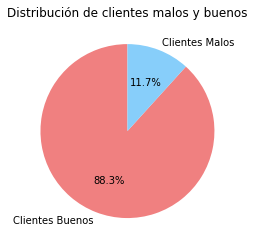

In [649]:
num_buenos = len(df[df['is_bad'] == False])
num_malos = len(df[df['is_bad'] == True])

sizes = [num_buenos, num_malos]
labels = ['Clientes Buenos', 'Clientes Malos']
colors = ['lightcoral', 'lightskyblue']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

plt.title('Distribución de clientes malos y buenos')
plt.show()

Este grafico nos sirve para tener un aproximado de la distribucion que podriamos llegar a ver en el momento en que el modelo empiece a predecir, el 11% de los clientes son marcados como malos

In [650]:
df_eda = pd.merge(original, nuevo, 'left', 'ID')
df_eda = df_eda.dropna(subset=['is_bad'])
df_eda.head(2)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,is_bad
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,True
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,True


El porcentaje de mujeres es  0.6710963455149501
El porcentaje de hombres es  0.3289036544850498
-----------------------------
Porcentaje de mujeres pertenecientes a la categoria malo  0.6415872197887142
Porcentaje de hombres pertenecientes a la categoria malo  0.35841278021128575


C:\Users\sebastian sossa\AppData\Local\Temp\ipykernel_40864\2024748327.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  porcentaje_mujeres_malo = len(df_eda[df_eda['CODE_GENDER'] == 'F'][df_eda['is_bad'] == True]) / len(df_eda[df_eda['is_bad'] == True])
C:\Users\sebastian sossa\AppData\Local\Temp\ipykernel_40864\2024748327.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  porcentaje_hombres_malo = len(df_eda[df_eda['CODE_GENDER'] == 'M'][df_eda['is_bad'] == True]) / len(df_eda[df_eda['is_bad'] == True])


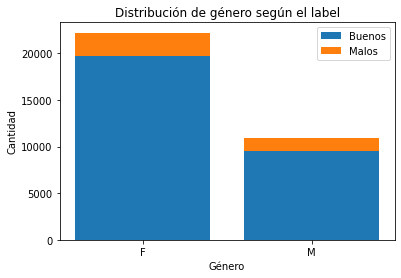

In [651]:
grouped_data = df_eda.groupby(['CODE_GENDER', 'is_bad'])

porcentaje_mujeres =  len(df_eda[df_eda['CODE_GENDER'] == 'F']) / df_eda.shape[0]
porcentaje_hombres =  len(df_eda[df_eda['CODE_GENDER'] == 'M']) / df_eda.shape[0]
print('El porcentaje de mujeres es ', porcentaje_mujeres)
print('El porcentaje de hombres es ', porcentaje_hombres)

porcentaje_mujeres_malo = len(df_eda[df_eda['CODE_GENDER'] == 'F'][df_eda['is_bad'] == True]) / len(df_eda[df_eda['is_bad'] == True])
porcentaje_hombres_malo = len(df_eda[df_eda['CODE_GENDER'] == 'M'][df_eda['is_bad'] == True]) / len(df_eda[df_eda['is_bad'] == True])
print('-----------------------------')
print('Porcentaje de mujeres pertenecientes a la categoria malo ', porcentaje_mujeres_malo)
print('Porcentaje de hombres pertenecientes a la categoria malo ', porcentaje_hombres_malo)


gender_data = grouped_data.size().unstack()

fig, ax = plt.subplots()
ax.bar(gender_data.index, gender_data[False], label='Buenos')
ax.bar(gender_data.index, gender_data[True], bottom=gender_data[False], label='Malos')

ax.set_xlabel('Género')
ax.set_ylabel('Cantidad')
ax.set_title('Distribución de género según el label')
ax.legend()

plt.show()

Podemos ver que la cantidad de mujeres en el data ser es el doble que la cantidad de hombres, teniendo un 67% sobre un 32% de hombres y en el caso de los marcados como clientes malos sigue un tendencia similar 64% mujeres y 35% hombres

Porcentaje de clientes sin carro ->  0.6227121715493809
Porcentaje de clientes con carro ->  0.37728782845061914
-----------------------------
Porcentaje de clientes sin carro pertenecientes a la categoria malo  ->  0.637979902087091
Porcentaje de clientes con carro  pertenecientes a la categoria malo  ->  0.36202009791290907


C:\Users\sebastian sossa\AppData\Local\Temp\ipykernel_40864\848614140.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  porcentaje_con_carro_malo = len(df_eda[df_eda['FLAG_OWN_CAR'] == 'Y'][df_eda['is_bad'] == True]) / len(df_eda[df_eda['is_bad'] == True])
C:\Users\sebastian sossa\AppData\Local\Temp\ipykernel_40864\848614140.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  porcentaje_sin_malo = len(df_eda[df_eda['FLAG_OWN_CAR'] == 'N'][df_eda['is_bad'] == True]) / len(df_eda[df_eda['is_bad'] == True])


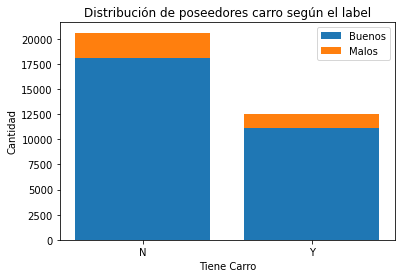

In [652]:
grouped_data1 = df_eda.groupby(['FLAG_OWN_CAR', 'is_bad'])

porcentaje_con_carro =  len(df_eda[df_eda['FLAG_OWN_CAR'] == 'Y']) / df_eda.shape[0]
porcentaje_sin_carro =  len(df_eda[df_eda['FLAG_OWN_CAR'] == 'N']) / df_eda.shape[0]
print('Porcentaje de clientes sin carro -> ', porcentaje_sin_carro)
print('Porcentaje de clientes con carro -> ', porcentaje_con_carro)


porcentaje_con_carro_malo = len(df_eda[df_eda['FLAG_OWN_CAR'] == 'Y'][df_eda['is_bad'] == True]) / len(df_eda[df_eda['is_bad'] == True])
porcentaje_sin_malo = len(df_eda[df_eda['FLAG_OWN_CAR'] == 'N'][df_eda['is_bad'] == True]) / len(df_eda[df_eda['is_bad'] == True])
print('-----------------------------')
print('Porcentaje de clientes sin carro pertenecientes a la categoria malo  -> ', porcentaje_sin_malo)
print('Porcentaje de clientes con carro  pertenecientes a la categoria malo  -> ', porcentaje_con_carro_malo)

carro_data = grouped_data1.size().unstack()

fig, ax = plt.subplots()
ax.bar(carro_data.index, carro_data[False], label='Buenos')
ax.bar(carro_data.index, carro_data[True], bottom=carro_data[False], label='Malos')

ax.set_xlabel('Tiene Carro')
ax.set_ylabel('Cantidad')
ax.set_title('Distribución de poseedores carro según el label')
ax.legend()

plt.show()

La mayoria de personas en el dataset no tienen carro, pero los clientes clasificados como clientes malos, son mas propensos a no tener carro

Porcentaje de clientes sin casa ->  0.32684989429175476
Porcentaje de clientes con casa ->  0.6731501057082453


C:\Users\sebastian sossa\AppData\Local\Temp\ipykernel_40864\3969908098.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  porcentaje_con_casa_malo = len(df_eda[df_eda['FLAG_OWN_REALTY'] == 'Y'][df_eda['is_bad'] == True]) / len(df_eda[df_eda['is_bad'] == True])


-----------------------------
Porcentaje de clientes sin casa pertenecientes a la categoria malo  ->  0.36253542901314095
Porcentaje de clientes con casa pertenecientes a la categoria malo  ->  0.637464570986859


C:\Users\sebastian sossa\AppData\Local\Temp\ipykernel_40864\3969908098.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  porcentaje_sin_casa_malo = len(df_eda[df_eda['FLAG_OWN_REALTY'] == 'N'][df_eda['is_bad'] == True]) / len(df_eda[df_eda['is_bad'] == True])


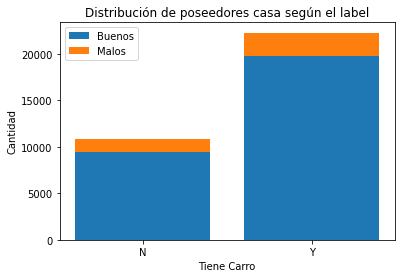

In [653]:
grouped_data2 = df_eda.groupby(['FLAG_OWN_REALTY', 'is_bad'])

porcentaje_con_casa =  len(df_eda[df_eda['FLAG_OWN_REALTY'] == 'Y']) / df_eda.shape[0]
porcentaje_sin_casa =  len(df_eda[df_eda['FLAG_OWN_REALTY'] == 'N']) / df_eda.shape[0]
print('Porcentaje de clientes sin casa -> ', porcentaje_sin_casa)
print('Porcentaje de clientes con casa -> ', porcentaje_con_casa)

porcentaje_con_casa_malo = len(df_eda[df_eda['FLAG_OWN_REALTY'] == 'Y'][df_eda['is_bad'] == True]) / len(df_eda[df_eda['is_bad'] == True])
porcentaje_sin_casa_malo = len(df_eda[df_eda['FLAG_OWN_REALTY'] == 'N'][df_eda['is_bad'] == True]) / len(df_eda[df_eda['is_bad'] == True])
print('-----------------------------')
print('Porcentaje de clientes sin casa pertenecientes a la categoria malo  -> ', porcentaje_sin_casa_malo)
print('Porcentaje de clientes con casa pertenecientes a la categoria malo  -> ', porcentaje_con_casa_malo)


casa_data = grouped_data2.size().unstack()

fig, ax = plt.subplots()
ax.bar(casa_data.index, casa_data[False], label='Buenos')
ax.bar(casa_data.index, casa_data[True], bottom=casa_data[False], label='Malos')

ax.set_xlabel('Tiene Carro')
ax.set_ylabel('Cantidad')
ax.set_title('Distribución de poseedores casa según el label')
ax.legend()

plt.show()

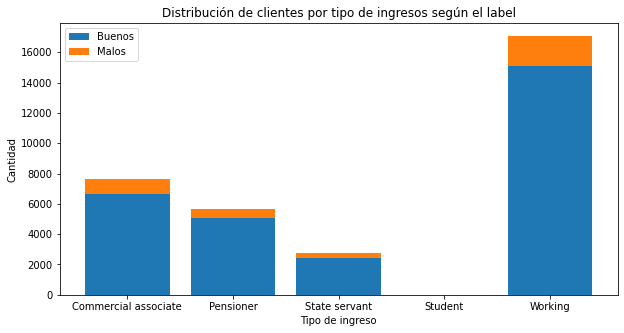

In [654]:
grouped_data3 = df_eda.groupby(['NAME_INCOME_TYPE', 'is_bad'])

incometype_data = grouped_data3.size().unstack()

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(incometype_data.index, incometype_data[False], label='Buenos')
ax.bar(incometype_data.index, incometype_data[True], bottom=incometype_data[False], label='Malos')

ax.set_xlabel('Tipo de ingreso')
ax.set_ylabel('Cantidad')
ax.set_title('Distribución de clientes por tipo de ingresos según el label')
ax.legend()

plt.show()

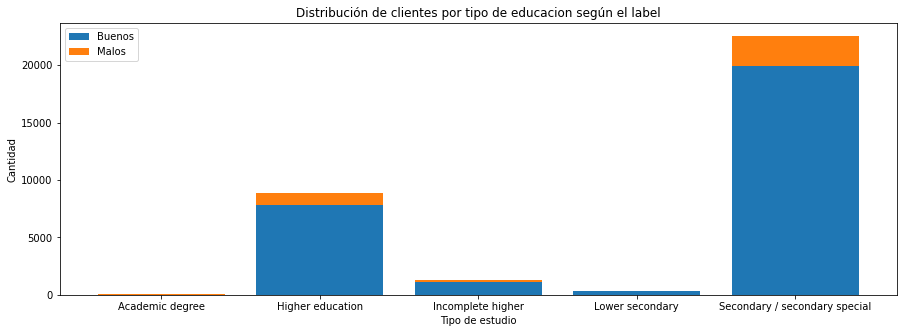

In [655]:


grouped_data4 = df_eda.groupby(['NAME_EDUCATION_TYPE', 'is_bad'])
Eeducationtype_data = grouped_data4.size().unstack()

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(Eeducationtype_data.index, Eeducationtype_data[False], label='Buenos')
ax.bar(Eeducationtype_data.index, Eeducationtype_data[True], bottom=Eeducationtype_data[False], label='Malos')

ax.set_xlabel('Tipo de estudio')
ax.set_ylabel('Cantidad')
ax.set_title('Distribución de clientes por tipo de educacion según el label')
ax.legend()


plt.show()

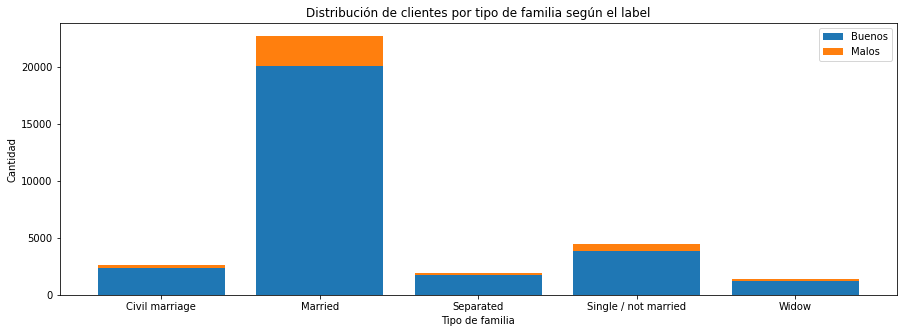

In [656]:
grouped_data5 = df_eda.groupby(['NAME_FAMILY_STATUS', 'is_bad'])
family_status_data = grouped_data5.size().unstack()

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(family_status_data.index, family_status_data[False], label='Buenos')
ax.bar(family_status_data.index, family_status_data[True], bottom=family_status_data[False], label='Malos')

ax.set_xlabel('Tipo de familia')
ax.set_ylabel('Cantidad')
ax.set_title('Distribución de clientes por tipo de familia según el label')
ax.legend()


plt.show()

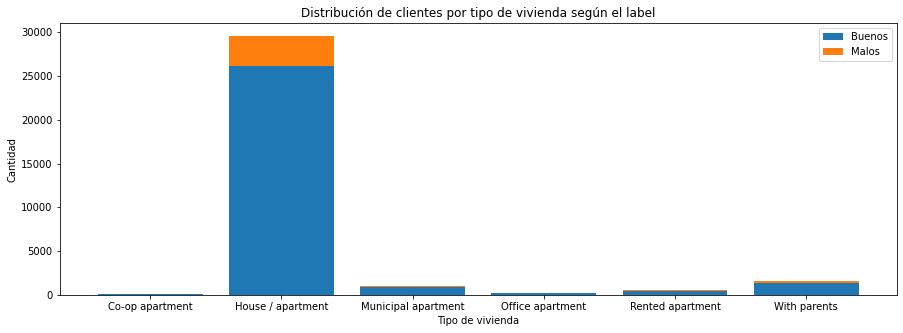

In [657]:
grouped_data6 = df_eda.groupby(['NAME_HOUSING_TYPE', 'is_bad'])
housing_type_data = grouped_data6.size().unstack()

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(housing_type_data.index, housing_type_data[False], label='Buenos')
ax.bar(housing_type_data.index, housing_type_data[True], bottom=housing_type_data[False], label='Malos')

ax.set_xlabel('Tipo de vivienda')
ax.set_ylabel('Cantidad')
ax.set_title('Distribución de clientes por tipo de vivienda según el label')
ax.legend()


plt.show()

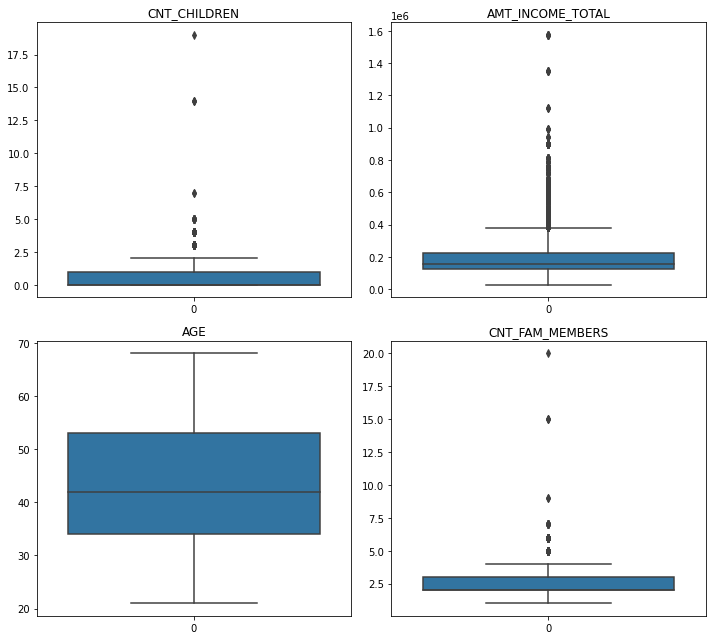

In [658]:
variables = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AGE', 'CNT_FAM_MEMBERS']
columns = 2
fig, axes = plt.subplots(len(variables) // columns, columns, figsize=(10, 3 * ((len(variables) // columns) + 1)))

for current_idx, variable in enumerate(variables):
    i = current_idx // columns
    j = current_idx % columns
    sns.boxplot(df[variable], ax=axes[i][j])
    axes[i][j].set_title(variable)
    axes[i][j].set_xlabel("")
    
plt.tight_layout()
plt.show()

Tenemos outliers en las variables analizadas con el boxplot, pero no los vamos a eliminar, los vamos a tratar con regulizador a la hora de crear el modelo 

In [659]:
df.head(1)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,EMPLEADO,DIAS_EMPLEADO,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,is_bad
0,5008804,1,1,1,0,427500.0,1,1,0,0,18,2.0,32,1,4542,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,True


## Modelo

### Splitting the data Normalizing data 

In [660]:
y = df['is_bad']
y = y.replace({True: 1, False: 0})

In [661]:
X = df.drop(['is_bad', 'ID', 'OCCUPATION_TYPE' ], axis=1)

Los datos que presenta el data set tienen diferentes rangos, como el AMT_INCOME_TOTAL, AGE, etc. Por lo que vamos a normalizar la data con el metodo min-max 

In [662]:
scaler1 = preprocessing.MinMaxScaler()
d1 = scaler1.fit_transform(X)
X = pd.DataFrame(d1, columns=X.columns)
X.head(3)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE,EMPLEADO,DIAS_EMPLEADO,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
0,1.0,1.0,1.0,0.0,0.258721,0.0,1.0,0.0,0.0,0.052632,0.234043,1.0,0.28906,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,1.0,1.0,0.0,0.258721,0.0,1.0,0.0,0.0,0.052632,0.234043,1.0,0.28906,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,1.0,0.0,0.055233,0.0,0.0,0.0,0.0,0.052632,0.787234,1.0,0.07217,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [663]:
# Split dataset with stratified data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [664]:
X_train.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE,EMPLEADO,DIAS_EMPLEADO,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
3832,1.0,1.0,0.0,0.000000,0.113372,0.0,0.0,1.0,1.0,0.052632,0.042553,1.0,0.067906,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25839,0.0,0.0,1.0,0.000000,0.098837,0.0,0.0,0.0,0.0,0.052632,0.872340,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19995,0.0,0.0,1.0,0.000000,0.101744,0.0,0.0,0.0,0.0,0.000000,0.978723,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16373,1.0,1.0,1.0,0.052632,0.098837,0.0,0.0,0.0,0.0,0.105263,0.574468,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
30053,1.0,0.0,1.0,0.052632,0.215116,0.0,0.0,0.0,0.0,0.105263,0.212766,1.0,0.162541,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Building the model

##### 1mer modelo

In [673]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build and fit the random forest classifier model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Predict the target values using the test set
y_pred = rfc.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      8819
           1       0.54      0.31      0.39      1114

    accuracy                           0.89      9933
   macro avg       0.73      0.64      0.67      9933
weighted avg       0.88      0.89      0.88      9933



En este caso el modelo tiene un bias que hacia la clase, ya que es la clase mayoritaria.

In [694]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=y_train)

# Initialize model with class weights
model = RandomForestClassifier(class_weight={0: class_weights[0], 1: class_weights[1]}, random_state=42)

# Oversample minority class using SMOTE
smote = SMOTE(random_state=42)
X_train_re, y_train_re = smote.fit_resample(X_train, y_train)

# Fit model on resampled data
model.fit(X_train_re, y_train_re)

# Predict probabilities for test set
y_pred = model.predict_proba(X_test)
y_pred = (y_pred[:, 1] >= 0.2).astype(int)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.74      0.83      8819
           1       0.25      0.68      0.37      1114

    accuracy                           0.74      9933
   macro avg       0.60      0.71      0.60      9933
weighted avg       0.87      0.74      0.78      9933



En este caso usamos un treshold, para aumentar la cantidad de predicciones en 1, logramos un recall en 1 de 68% y un 74% en 0, pero aun necesitamos mas datos para que el modelo aprenda de las clases clasificadas como cliente malo